In [155]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sys

import os.path as osp

### Set parameters for synthetic data

In [196]:
Q = 10 * np.eye(2)
Qsp = 100 * np.eye(2)
R = 20 * np.eye(2)
F = np.eye(2)
pD = 0.9
pS = 1.0
pB = 0.1
pSpw = 0.1

T = 50

side_size = 500

n_start = 10

## Generate Data

In [194]:
mvn = np.random.multivariate_normal
sample_new_crd = lambda : np.random.uniform(low = 0, high = side_size, size = 2)
rand = np.random.random

crd = list()
obs = list()
ids = list()
spawn = list()
birth = list()

crd.append([])
obs.append([])
ids.append([])
for n in range(n_start):
    crd_0 = sample_new_crd()
    crd[-1].append(crd_0.reshape(1,2))
    obs[-1].append(mvn(crd_0,R).reshape(1,2))
    ids[-1].append(n)

max_id = n_start
max_crd = 0
    
for t in range(1,T):
    crd[t-1] = np.vstack(crd[t-1])
    obs[t-1] = np.vstack(obs[t-1])
    ids[t-1] = np.array(ids[t-1])
    max_id = np.max((max_id,np.max(ids[t-1])))
    max_crd = np.max((max_crd,obs[t-1].max()))

    
    crd.append([])
    obs.append([])
    ids.append([])
    for c,i in zip(crd[t-1],ids[t-1]): 
        if rand() / len(crd[t-1]) < pS:
            new_crd = mvn(c,Q)
            crd[t].append(new_crd)
            ids[t].append(i)
            if rand() / len(crd[t-1]) < pD :
                new_obs = mvn(new_crd,R)
                obs[t].append(new_obs)
        if rand() < pSpw / len(crd[t-1]):
            spawn.append(t)
            new_crd = mvn(c,Qsp)
            crd[t].append(new_crd)
            ids[t].append(max_id + 1)
            max_id += 1
            if rand() / len(crd[t-1]) < pD :
                new_obs = mvn(new_crd,R)
                obs[t].append(new_obs)
    if rand() < pB:
        birth.append(t)
        new_crd = sample_new_crd()
        crd[t].append(new_crd)
        ids[t].append(max_id+1)
        if rand() < pD:
            new_obs = mvn(new_crd,R)
            obs[t].append(new_obs)
crd[-1] = np.vstack(crd[-1])
obs[-1] = np.vstack(obs[-1])
ids[-1] = np.array(ids[-1])

spawn = np.array([1 if t in spawn else 0 for t in range(0,T)]).reshape(-1,1)
birth = np.array([1 if t in birth else 0 for t in range(0,T) ]).reshape(-1,1)

## Inspect generated data

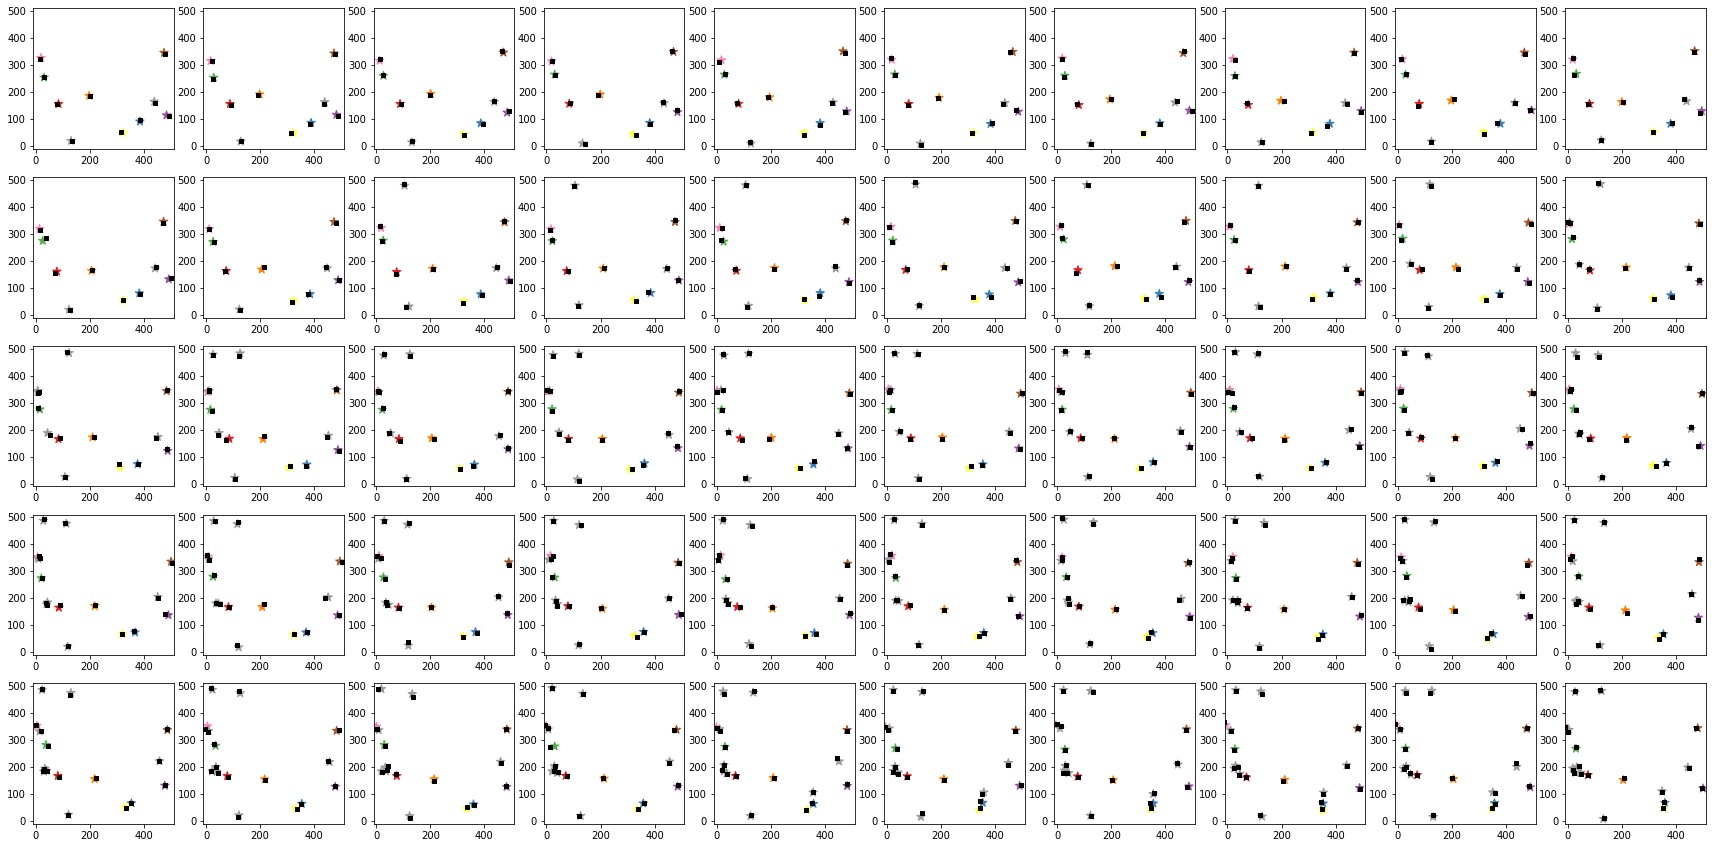

In [197]:
fig,ax = plt.subplots(5,10,figsize = (30,15),facecolor = "white")
ax = ax.flatten()

for t,(c,i) in enumerate(zip(crd,ids)):
    ax[t].scatter(c[:,0],
                  c[:,1],
                  c = plt.cm.Set1(i),
                  s= 80,
                  marker = "*",
                 )
    
    ax[t].scatter(obs[t][:,0],
                 obs[t][:,1],
                  c = "black",
                  marker = "s",
                  s = 10,
                 )
   # ax[t].axis("off")
    ax[t].set_aspect("equal")
    ax[t].set_xlim([-10,side_size + 10])
    ax[t].set_ylim([-10,side_size + 10])
    
plt.show()

## Format and compile output data

In [207]:
ground_truth = list()
for t,(c,i) in enumerate(zip(crd,ids)):
    _tmp = pd.DataFrame(c)
    _tmp.columns = ["x","y"]
    _tmp["time"] = t
    _tmp["cell"] = i
    ground_truth.append(_tmp)

ground_truth = pd.concat(ground_truth)

observations = list()
for t,o in enumerate(obs):
    _tmp = pd.DataFrame(o)
    _tmp.columns = ["x","y"]
    _tmp["time"] = t
    observations.append(_tmp)

observations = pd.concat(observations)

events = pd.DataFrame(np.hstack((spawn,birth)),
                     columns = ["spawning","birth"],
                      index = np.arange(T),
                     )

    

## Save generated data

In [209]:
set_name = "synth-001"
RES_DIR = "../data/synthetic"

ground_truth.to_csv(osp.join(RES_DIR,set_name + "-ground_truth" + ".tsv"), sep = "\t")
observations.to_csv(osp.join(RES_DIR,set_name + "-observations" + ".tsv"), sep = "\t")
events.to_csv(osp.join(RES_DIR,set_name + "-events" + ".tsv"), sep = "\t")

## Generate and save images of data

In [219]:
import cv2
round_max_crd = int(round(max_crd))
rect_size = 1
for t in range(len(crd)):
    img = np.zeros([round_max_crd,round_max_crd],dtype = np.uint8)
    img.fill(255)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for c in crd[t]:
        img = cv2.circle(img,
                        tuple(c.astype(int)),
                        radius = 14,
                        color = (68,68,68),
                        thickness = -2)
    for o in obs[t]:
        img = cv2.circle(img,
                        tuple(o.astype(int)),
                        radius = 10,
                        color = (0,0,255),
                        thickness = 2)
    
        

    cv2.imwrite(osp.join(RES_DIR,"imgs", str(t).zfill(3) + ".png"),img)

